# Gathering Influenza Related Data via the DELPHI Epidata API
### Purpose of this notebook
* Gather the Wikipedia Pageviews and ILInet data from the DELPHI epidata API
* Store the data into pandas DataFrames to facilitate analysis (in other notebooks)
* Create a DataFrame that maps Epiweeks to their corresponding Datetimes
* Explore the Data

*The relevant computed variables are stored in iPython's local data store to avoid recomputation. These variables can be accessed from other notebooks using the %store magic command*

In [1]:
import epidata as delphi
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from bs4 import BeautifulSoup
from collections import defaultdict
from datetime import datetime, timedelta
%matplotlib inline

%store -r pageViewResps
%store -r wILIresp
%store -r pageViews
%store -r wILI
%store -r epiweeksDf
%store -r rawPageViews

definedVariables = set(vars().keys())

#### Getting Wikipedia Page Views for Flu Related Articles

In [2]:
if 'pageViewResps' not in definedVariables:
    
    print("Calling the DELPHI epidata API for wikipedia pageviews")
    
    epidata = delphi.Epidata() # interface to CMU delphi API

    with open('./data/allarticles.txt') as f:
        fluRelatedArticles = [article.strip() for article in f]
    # API calls to the delphi epidata API
    pageViewResps = epidata.wiki(fluRelatedArticles, epidata.range(200750, 201652))['epidata']
    %store pageViewResps
else:
    print("Found pageViewResps")
pageViewResps[:1]

Found pageViewResps


[{'article': 'amantadine',
  'count': 2494,
  'epiweek': 200750,
  'hour': -1,
  'total': 962053104,
  'value': 2.59237249}]

#### Getting state level ILInet data

In [3]:
if 'wILIresp' not in definedVariables:
    
    print("Calling the DELPHI epidata API for ILInet data")
    rng = epidata.range('200750', '201652')
    wILIresp = epidata.fluview('nat', epiweeks=rng)['epidata']
    %store wILIresp
else:
    print("Found wILIresp")

wILIresp[:1]

Found wILIresp


[{'epiweek': 200701,
  'ili': 2.2694244711397,
  'issue': 201352,
  'lag': 364,
  'num_age_0': 2927,
  'num_age_1': 2481,
  'num_age_2': 2394,
  'num_age_3': None,
  'num_age_4': None,
  'num_age_5': 584,
  'num_ili': 8386,
  'num_patients': 369521,
  'num_providers': 1490,
  'region': 'nat',
  'release_date': '2013-12-31',
  'wili': 2.3781701478568}]

#### Putting pageViews API response data in DataFrame

In [4]:
if 'pageViews' not in definedVariables:
    pageToViews = defaultdict(list)
    pageViewsIndex = { week['epiweek'] for week in pageViewResps }
    pageViewsIndex = list(pageViewsIndex)
    pageViewsIndex.sort()

    # map each article to it's weekly view counts (from 2008 to 2016)
    for week in pageViewResps:
        page, weeklyViews = week['article'], week['count']
        pageToViews[page].append(weeklyViews)

    pageViews = pd.DataFrame.from_dict(pageToViews, orient='index', dtype='int')
    pageViews = pageViews.transpose()
    pageViews = pageViews.fillna( pageViews.median() )
    # convert to ints, for some reasons transpose() coereces to floats
    for column in pageViews.columns:
        pageViews[column] = pageViews[column].astype('int')
    pageViews.index = pageViewsIndex
    
    # API resp is missing the occasional 53rd epiweek, so fill
    w200853 = [ np.median(pageViews.loc[:200852, article].values) for article in pageViews.columns]
    w201453 = [ np.median(pageViews.loc[:201452, article].values) for article in pageViews.columns]
    pageViews.loc[200853] = w200853
    pageViews.loc[201453] = w201453
    pageViews = pageViews.sort_index()
    %store pageViews
else:
    print("Found pageViews")
    
pageViews.loc[200852:200902]

Found pageViews


,influenza_prevention,influenzavirus_c,influenza_a_virus_subtype_h1n2,influenza,influenza_vaccine,equine_influenza,avian_influenza,hemagglutinin_(influenza),influenza_a_virus_subtype_h7n7,cough,...,influenza_pandemic,influenza_a_virus_subtype_h7n2,common_cold,swine_influenza,cat_flu,amantadine,shivering,canine_influenza,rhinorrhea,flu_season
200852,0.0,156.0,14.0,21535.0,1568.0,248.0,2476.0,0.0,16.0,8411.0,...,1053.0,6.0,21232.0,39.0,215.0,3323.0,1293.0,232.0,1789.0,527.0
200853,0.0,209.0,11.0,21535.0,1810.0,311.0,4651.0,0.0,11.0,7676.0,...,1457.0,13.0,16659.0,24.0,302.0,3885.0,1278.0,232.0,1888.0,519.0
200901,0.0,206.0,16.0,30309.0,2155.0,320.0,4611.0,28.0,15.0,11497.0,...,1343.0,20.0,27074.0,46.0,310.0,4951.0,1680.0,278.0,2643.0,887.0
200902,0.0,234.0,6.0,32053.0,2359.0,337.0,4710.0,28.0,10.0,10605.0,...,1624.0,9.0,24967.0,42.0,307.0,4518.0,1767.0,282.0,2838.0,754.0


#### Putting ILInet API response in DataFrame

In [5]:
if 'wILI' not in definedVariables:
    wILIvalues = [ week['ili'] for week in wILIresp ]
    wILIindex = [ week['epiweek'] for week in wILIresp ]
    wILIindex.sort()
    wILI = pd.DataFrame(wILIvalues, columns=['Weekly ILI'], index=wILIindex)    
    %store wILI
else:
    print("Found wILI")
wILI.loc[200850:200903]

Found wILI


,Weekly ILI
200850,1.499207
200851,1.629816
200852,2.155612
200853,2.020527
200901,1.545662
200902,1.642237
200903,1.965238


#### Creating DataFrame that maps Epiweek number to a datetime
This will prove useful when doing converting between epiweeks and datetimes. The data is taken from 
> https://ibis.health.state.nm.us/resource/MMWRWeekCalendar.html

Instead of sending a GET request, I have pasted the source html in the data folder.

In [6]:
if 'epiweeksDf' not  in definedVariables:
    
    print("Creating epiweeks dataframe")
    
    with open("data/epiweeks.html") as f:
        html = f.read().replace('\n', '')
        soup = BeautifulSoup( html, 'lxml' )
        tables = soup.findAll("table", {'class':'Info'})

    epiweeksDf = pd.DataFrame()

    for table in tables[::-1]:
        rows = iter(table.findAll('tr'))
        next(rows) # skip header
        years = [int(year) for year in next(rows).text.split()]
        df = pd.DataFrame(columns=years)
        for i, row in enumerate(rows):
            weeks = [ datetime.strptime(d, '%m/%d/%Y') - timedelta(days=6) for d in row.text.split()[1:] ]
            if len(weeks) >= 5 :
                df.loc[i+1] = weeks
        epiweeksDf = pd.concat([epiweeksDf, df], axis=1)
    # handle the occasional 53rd week
    epiweeksDf.loc[53] = [0] * 15
    epiweeksDf.loc[53, 2008] = datetime(2008, 12, 28)
    epiweeksDf.loc[53, 2014] = datetime(2008, 12, 28)
    
    %store epiweeksDf

else:
    print("Found epiweeksDf")

epiweeksDf[-5:]

Found epiweeksDf


,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
49,2006-12-03 00:00:00,2007-12-02 00:00:00,2008-11-30 00:00:00,2009-12-06 00:00:00,2010-12-05 00:00:00,2011-12-04 00:00:00,2012-12-02 00:00:00,2013-12-01 00:00:00,2014-11-30 00:00:00,2015-12-06 00:00:00,2016-12-04 00:00:00,2017-12-03 00:00:00,2018-12-02 00:00:00,2019-12-01 00:00:00,2020-11-29 00:00:00
50,2006-12-10 00:00:00,2007-12-09 00:00:00,2008-12-07 00:00:00,2009-12-13 00:00:00,2010-12-12 00:00:00,2011-12-11 00:00:00,2012-12-09 00:00:00,2013-12-08 00:00:00,2014-12-07 00:00:00,2015-12-13 00:00:00,2016-12-11 00:00:00,2017-12-10 00:00:00,2018-12-09 00:00:00,2019-12-08 00:00:00,2020-12-06 00:00:00
51,2006-12-17 00:00:00,2007-12-16 00:00:00,2008-12-14 00:00:00,2009-12-20 00:00:00,2010-12-19 00:00:00,2011-12-18 00:00:00,2012-12-16 00:00:00,2013-12-15 00:00:00,2014-12-14 00:00:00,2015-12-20 00:00:00,2016-12-18 00:00:00,2017-12-17 00:00:00,2018-12-16 00:00:00,2019-12-15 00:00:00,2020-12-13 00:00:00
52,2006-12-24 00:00:00,2007-12-23 00:00:00,2008-12-21 00:00:00,2009-12-27 00:00:00,2010-12-26 00:00:00,2011-12-25 00:00:00,2012-12-23 00:00:00,2013-12-22 00:00:00,2014-12-21 00:00:00,2015-12-27 00:00:00,2016-12-25 00:00:00,2017-12-24 00:00:00,2018-12-23 00:00:00,2019-12-22 00:00:00,2020-12-20 00:00:00
53,0,0,2008-12-28 00:00:00,0,0,0,0,0,2008-12-28 00:00:00,0,0,0,0,0,0


### Aligning and aggregating QUAC pageviews to epiweeks

In [7]:
if 'rawPageViews' not in definedVariables:
    rawHourlyPageViews = pd.read_csv('data/LANL/wiki/en_flu_raw.csv')
    rawHourlyPageViews = rawHourlyPageViews.set_index('timestamp')
    rawHourlyPageViews.index = rawHourlyPageViews.index.to_datetime()

    rawPageViews = pd.DataFrame(columns=rawHourlyPageViews.columns)

    for year in range(2007, 2015):
        for epiweekNum, start in enumerate(epiweeksDf[year]):
            if start == 0:
                continue
            end = start +  timedelta(days=6, hours=23)
            mask = ((rawHourlyPageViews.index >= start) & 
                    (rawHourlyPageViews.index <= end))
            # aggregate on epiweeks
            thisEpiweekPageViews = rawHourlyPageViews.loc[mask].sum()
            epiweekNum = str(epiweekNum) if epiweekNum >= 10 else '0' + str(epiweekNum)
            epiweekWithYear = int(str(year) + epiweekNum) + 1
            rawPageViews.loc[epiweekWithYear] = thisEpiweekPageViews.values
    # coerce to ints
    for col in rawPageViews.columns:
        rawPageViews[col] = rawPageViews[col].astype('int')
    # convert column names to make them the same as the pageViews df
    rawPageViews.columns = [ article[3:].lower() if len(article) >= 3 else article
                             for article in rawPageViews.columns ]
    rawPageViews = rawPageViews.loc[200750:201409]
    
    %store rawPageViews
else:
    print("Found rawPageViews")

rawPageViews.loc[200850:200902]

Found rawPageViews


,amantadine,antiviral_drugs,avian_influenza,canine_influenza,cat_flu,chills,common_cold,cough,equine_influenza,fatigue_(medical),...,rhinorrhea,rimantadine,shivering,sore_throat,swine_influenza,viral_neuraminidase,viral_pneumonia,vomiting,zanamivir,en
200850,4850,206,4657,238,284,586,27012,9695,382,7427,...,2593,410,1592,2087,37,0,1373,11274,699,1229318871
200851,4233,188,4059,272,233,614,27089,9718,494,7504,...,2565,453,1625,2195,33,0,1271,10932,884,1205690965
200852,3320,164,2430,225,215,574,20785,8331,243,4232,...,1787,416,1279,5902,39,0,1053,9024,803,1043287624
200853,7574,202,2717,272,267,674,22749,9411,235,3556,...,2040,417,1305,7662,41,43,1232,12198,636,1126154050
200901,4939,178,4564,271,309,625,26426,11441,314,4129,...,2637,577,1656,9664,45,235,1547,10920,943,1275054281
200902,4512,179,4647,274,306,615,24447,10553,332,4411,...,2836,613,1751,7561,42,238,1529,11676,1468,1335297129


In [8]:
QUACepiweeks, DELPHIepiweeks = set(rawPageViews.index), set(pageViews.index)
commonEpiweeks = list( QUACepiweeks.intersection(DELPHIepiweeks) )
commonEpiweeks.sort()

QUACarticles, DELPHIarticles = set(rawPageViews.columns), set(pageViews.columns)
commonArticles = QUACarticles.intersection(DELPHIarticles)

diff= rawPageViews.loc[commonEpiweeks, commonArticles] - pageViews.loc[commonEpiweeks, commonArticles]
diff[['influenza', 'influenza_a_virus', 'flu_season', 'influenza_vaccine', 
      'common_cold', 'influenza_a_virus_subtype_h1n2']][:3]

,influenza,influenza_a_virus,flu_season,influenza_vaccine,common_cold,influenza_a_virus_subtype_h1n2
200750,-48.0,-16.0,-4.0,-5.0,-401.0,0.0
200751,-55.0,-4.0,-1.0,-31.0,-437.0,0.0
200752,-31.0,-3.0,-3.0,-2.0,-540.0,0.0


### Correlation between Pageviews and wILI

In [9]:
def epiweekToDatetime(epiweek):
    epiweek = str(epiweek)
    return datetime.strptime(epiweek + '6', "%Y%W%w") - timedelta(days=6)

pearsonCoefs = []
for article in pageViews.columns:
    df = pd.DataFrame({'wILI': wILI.loc[200750:201409, 'Weekly ILI'].values,
                       'Views': pageViews.loc[200750:201409, article].values})
    pearsonCoefs.append( (article, df.corr().loc['Views', 'wILI'] ) )
pearsonCoefs.sort(key=lambda t: t[1], reverse=True) # sort by pearson coeff
topArticles = [article for article, _ in pearsonCoefs[:10]] # top 10
pearsonCoefs[:10]

[('influenza_a_virus', 0.60410445166627791),
 ('influenza_prevention', 0.45434976735415522),
 ('common_cold', 0.45429982280087783),
 ('flu_season', 0.43658456293047376),
 ('influenza', 0.42434633316156162),
 ('influenza_a_virus_subtype_h1n2', 0.42308749424698788),
 ('viral_pneumonia', 0.40695773174997651),
 ('fever', 0.39964290368811184),
 ('influenza_vaccine', 0.39714292906548171),
 ('oseltamivir', 0.37395625719005771)]

### Graph using the DELPHI data
Due to mass media coverage, the 2009 flu season introduces a lot of noise into any potential model correlating wikipedia page views to wILI.

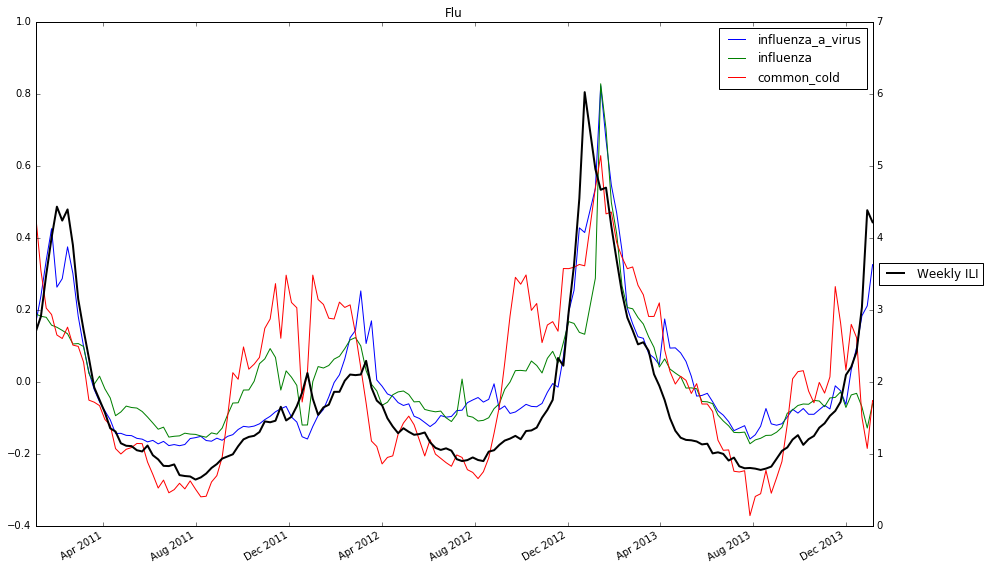

In [10]:
#plotDf.index = list( map(epiweekToDatetime, plotDf.index) )
fig, ax = plt.subplots()
ax2 = ax.twinx()
plotCols = ['influenza_a_virus', 'influenza', 'common_cold']
plotDf = pageViews.loc[201101:201401, plotCols]
plotDf.index = list( map(epiweekToDatetime, plotDf.index) )

# normalize the page views
plotDf = (plotDf - plotDf.mean() ) / (plotDf.max() - plotDf.min() )
plotDf.plot(ax=ax, figsize=(15, 10))
wiliPlotDf = wILI.loc[201101:201401]
wiliPlotDf.index = list( map(epiweekToDatetime, wiliPlotDf.index) )
wiliPlotDf.plot(ax=ax2, color='black', linewidth=2)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("Flu")

### Graping using the LANL Data

In [11]:
# ground truth data (CDC wILI)
truth = pd.read_csv('data/LANL/en_flu_2011-01-01_2014-01-04.csv', header=None)
truth.columns = ['Date', 'wILI']
truth.set_index('Date', inplace=True)
truth.index = pd.to_datetime(truth.index)

In [12]:
# LANL hourly wikipedia views data
rawHourlyPageViews = pd.read_csv('data/LANL/wiki/en_flu_raw.csv')
rawHourlyPageViews = rawHourlyPageViews.set_index('timestamp')
rawHourlyPageViews.index = rawHourlyPageViews.index.to_datetime()
# resample from hourly to daily
feats = rawHourlyPageViews.resample('D').sum()
# resample from daily to weekly (Starts on sundays to align with the truth data)
feats = feats.resample('W-SAT').sum()

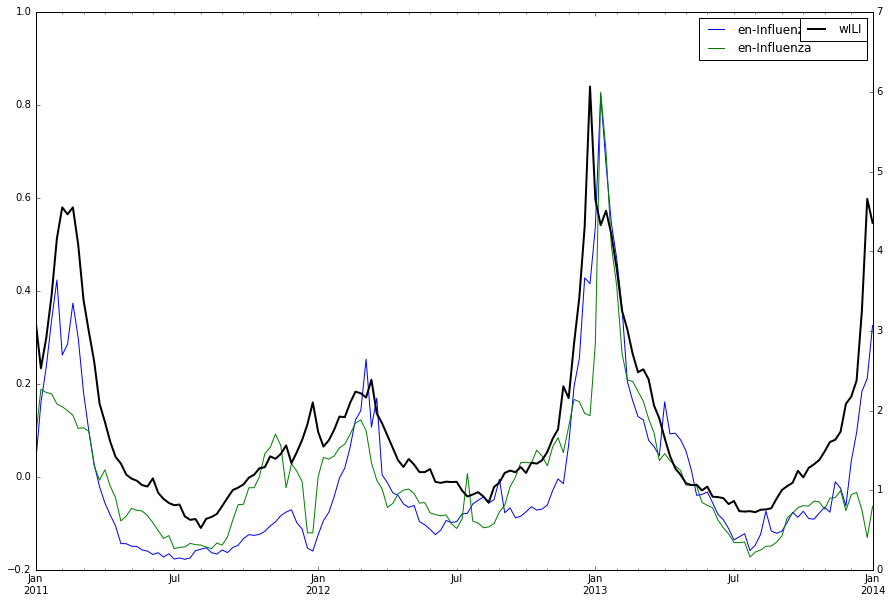

In [13]:
feats = feats.loc['2011-01-01':'2014-01-04']
plotCols = ['en-Influenza_A_virus', 'en-Influenza']
normedFeats = (feats - feats.mean()) / (feats.max() - feats.min())
fig, ax = plt.subplots()
ax2 = ax.twinx()
normedFeats[plotCols].plot(ax=ax, figsize=(15,10))
truth.plot(ax=ax2, color='black', linewidth=2)